# Data Exploration and Classification Pipeline

In the following notebook we will be exploring various ways to analyze and visualize our dataset, as well as the importance of feature extraction on classifier performance. We will be using the classic spam vs ham dataset, where each datapoint is a text document representing an email, and each label is either "spam" or "ham"

The primary challange of Natural Language Processing (NLP) is that text data is inherently categorical, while Machine Learning^{TM} models require numerical representations of data. A majority of present day research centers around efficient and effective ways of converting text data into a vectorized form. Today, we will explore three different approaches to solving this problem: Bag of Word, TFiDF weights, and Word2Vec. We will begin by doing some cursory analysis of the dataset. Next, we will explore some standard NLP data cleaning techniques. Finally, we will attempt to build classifiers and put each of our feature extraction techniques to the test

In [209]:
#Begin with some import housekeeping
import pandas as pd
import gensim, wordcloud
import seaborn as sns
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import pos_tag, word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [73]:
# Load in the dataset
data = pd.read_csv("spam.csv", encoding = "latin-1")
data = data[['v1', 'v2']]
data = data.rename(columns = {'v1': 'label', 'v2': 'text'})

## Exploration

The first step to beginning the data science process is to get a better sense of your data. Let's examine some basic pandas functionality that can help us in that process

In [81]:
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [82]:
data.describe()

,label,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


Now let's try and visualize the distribution of our labels

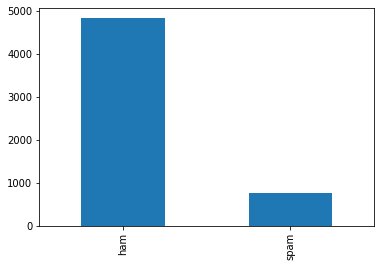

In [83]:
data.label.value_counts().plot.bar();

As you can see, there is an inequity in our class distribution. This is a common problem in ML applications and is something to keep in mind going forward!

At this point, it might be helpful to begin compiling our own statistics about the data, and augmenting the existing features with these additional statistics. Using domain knowledge, we can infer that messege length might be an import feature of emails, and is also an easy to calculate numerical feature. See if you can create a column called 'length' that contains the length of each messege

In [86]:
data['length'] = data['text'].apply(len) # don't give this to them

Now let's visualize our newly added feature

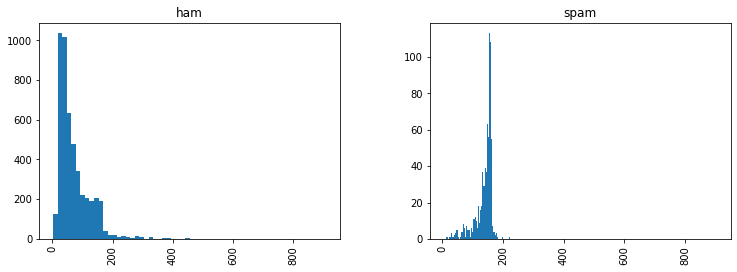

In [88]:
data.hist(column='length',by='label',bins=60,figsize=(12,4));
plt.xlim(-40,950);

It appears that the length distribution of messages varies between the two classes. To get a more empirical view, see if you can calculate the mean, median, and standard deviation of length for each class. This is a great exercise, especially if you are unfamiliar with pandas, in using your greatest resource as a programmer: The Internet!

Hint: try looking into conditional selectors for pandas dataframes

In [95]:
spam_median = None
spam_mean = data[data['label'] == 'spam']['length'].mean() # don't give these to them
spam_std = None

ham_median = None
ham_mean = data[data['label'] == 'ham']['length'].mean()
ham_std = None

print("Spam Statistics:\nMean:\t\t{0}\nMedian:\t\t{1}\nStandard Dev:\t{2}".format(spam_mean, spam_median, spam_std))
print("")
print("Ham Statistics:\nMean:\t\t{0}\nMedian:\t\t{1}\nStandard Dev:\t{2}".format(ham_mean, ham_median, ham_std))

Spam Statistics:
Mean:		138.8661311914324
Median:		None
Standard Dev:	None

Ham Statistics:
Mean:		71.02362694300518
Median:		None
Standard Dev:	None


Finally, we should probably explore the types of words that are present in both the spam and ham emails. An easy and popular way to do this is with wordclouds. First, we must separate the spam data from the ham data. Try using those conditional selectors you learned about in the previous part

In [96]:
def show_wordcloud(data_spam_or_ham, title):
    text = ' '.join(data_spam_or_ham['text'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='lightgrey',
                    colormap='viridis', width=800, height=600).generate(text)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=20 )
    plt.show()

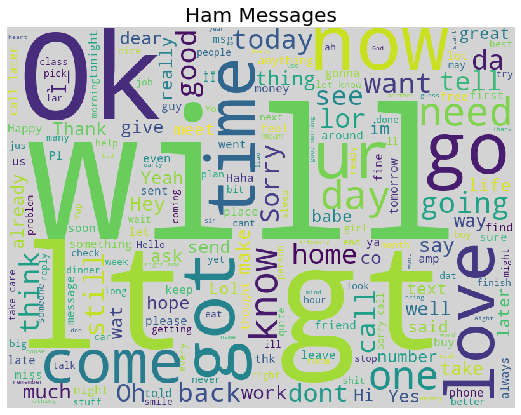

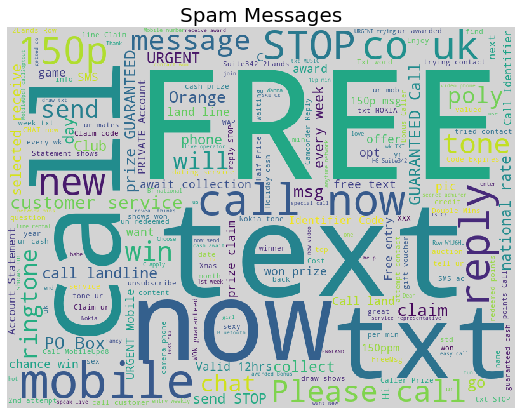

In [136]:
ham_data = data[data['label'] == 'ham']
spam_data = data[data['label'] == 'spam'] # don't give this to them

show_wordcloud(ham_data, "Ham Messages")
show_wordcloud(spam_data, "Spam Messages")

# Preprocessing

Another quintessential part of the datascience pipe-line is data preprocessing. If you've ever taken a datascience class at Cal (like data8 or data100) you were probably fortunate enough to work with a very clean and well formatted dataset. Real-world data is messy, and it takes a lot of work to get it into a state that is ready to be used by ML models. Let's take a look

In [114]:
for i in range(5):
    print(spam_data.sample()['text'].values[0])
    print("")

T-Mobile customer you may now claim your FREE CAMERA PHONE upgrade & a pay & go sim card for your loyalty. Call on 0845 021 3680.Offer ends 28thFeb.T&C's apply

As a Registered Subscriber yr draw 4 a å£100 gift voucher will b entered on receipt of a correct ans. When are the next olympics. Txt ans to 80062

FreeMsg Today's the day if you are ready! I'm horny & live in your town. I love sex fun & games! Netcollex Ltd 08700621170150p per msg reply Stop to end

Eerie Nokia tones 4u, rply TONE TITLE to 8007 eg TONE DRACULA to 8007 Titles: GHOST, ADDAMSFA, MUNSTERS, EXORCIST, TWILIGHT www.getzed.co.uk POBox36504W45WQ 150p 

Had your mobile 11mths ? Update for FREE to Oranges latest colour camera mobiles & unlimited weekend calls. Call Mobile Upd8 on freefone 08000839402 or 2StopTxt



As you can see, the data is messy: full of stray punctuation, numbers, and symbols. Part of NLP preprocessing is to remove all punctionuation from the text. Additionally, we note that words that are very common in the english language such as "the" or "a" have minimal semantic meaning, and are therefore just added noise to our model. These are referred to as stopwords, and it is also common to remove those words as well

In [119]:
# NLTK is an industry standaard library that comes with many NLP tools, one of which is a pre-formed 
# collection of stopwords
import nltk
from nltk.corpus import stopwords
# nltk.download() # Comment out this line after the first time this cell is run
english_stopwords = stopwords.words("english")
english_stopwords[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

Now it's your turn. Use the above stopwords set, as well as basic python string and list functions to write a preprossing function that tokenizes each text, removes punctutation, and removes stopwords. 

In [155]:
english_stopwords = set(english_stopwords)
ham_data_cpy = ham_data.copy()
spam_data_cpy = spam_data.copy()

def preprocess(message):
    """
    Function to remove punctuation and stopwords from our text data
    
    message: a string containing the test of one spam or ham email
    returns: a list of individual words, with all non-alpha characters and stopwords removed, lowercased
    """
    # Don't give them this
    words = [word.lower() for word in message.split() if word.isalpha() and not word in english_stopwords and len(word) > 1]
    return words

ham_data_cpy['text'] = ham_data_cpy['text'].apply(preprocess)
spam_data_cpy['text'] = spam_data_cpy['text'].apply(preprocess)
data['text'].apply(preprocess).head()

0    [go, jurong, available, bugis, great, world, l...
1                                    [ok, joking, wif]
2    [free, entry, wkly, comp, win, fa, cup, final,...
3                           [dun, say, early, already]
4            [nah, think, goes, lives, around, though]
Name: text, dtype: object

Now that we've cleaned and tokenized our text data, we are finally in a position to more closely examine word counts for each class. Luckily, NLTK comes with tools to help us visualize this

In [237]:
words_data_ham = ham_data_cpy['text'].tolist()
words_data_spam = spam_data_cpy['text'].tolist()

# Construct flattened list of all ham words
list_ham_words = []
for sublist in words_data_ham:
    for item in sublist:
        list_ham_words.append(item)

# Construct flattened list of all spam words
list_spam_words = []
for sublist in words_data_spam:
    for item in sublist:
        list_spam_words.append(item)
        
# Corpus of all words
corpus = words_data_ham + words_data_spam
corpus = [" ".join(doc) for doc in corpus]

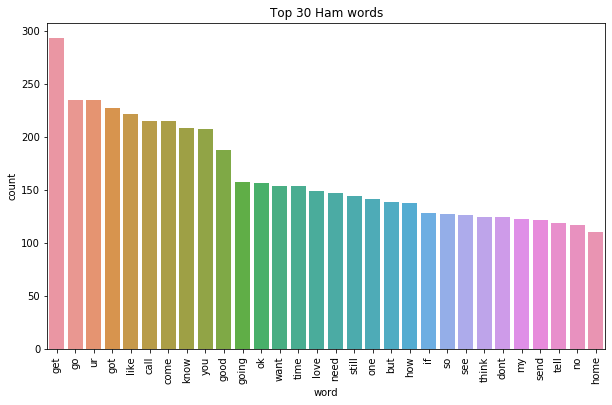

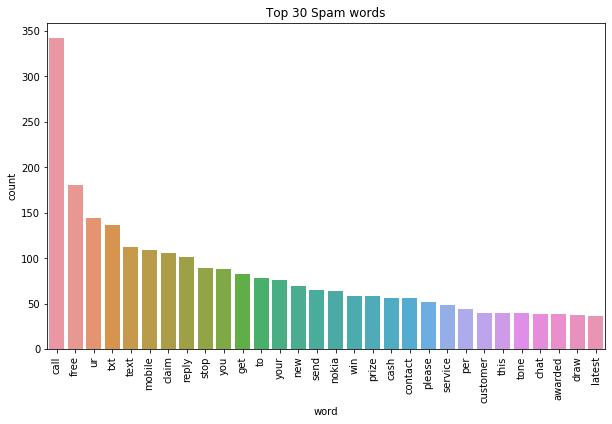

In [161]:
# Visualize with NLTK and Seaborn
fdist_ham  = nltk.FreqDist(list_ham_words)
fdist_spam = nltk.FreqDist(list_spam_words)

df_hamwords_top30_nltk  = pd.DataFrame(fdist_ham.most_common(30),  columns=['word', 'count'])
df_spamwords_top30_nltk = pd.DataFrame(fdist_spam.most_common(30), columns=['word', 'count'])

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', 
            data=df_hamwords_top30_nltk, ax=ax)
plt.title("Top 30 Ham words")
plt.xticks(rotation='vertical');

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', 
            data=df_spamwords_top30_nltk, ax=ax)
plt.title("Top 30 Spam words")
plt.xticks(rotation='vertical');

## Feature Extraction

We will now explore the problem of converting our text data into numerical data

### Bag of Words

In [238]:
from sklearn.feature_extraction.text import CountVectorizer
bow_transformer = CountVectorizer(analyzer = preprocess).fit(corpus) # Maybe have them do this
bow_transformer.transform(data['text'])

<5572x6012 sparse matrix of type '<class 'numpy.int64'>'
	with 33354 stored elements in Compressed Sparse Row format>

In [239]:
print(len(bow_transformer.vocabulary_))

6012


In [177]:
# some BoW examples
sample_spam = spam_data.sample()['text'].tolist()[0]
bow_sample_spam = bow_transformer.transform([sample_spam])
print('Spam sample:')
print(sample_spam)
print('Spam Transformed:')
print(bow_sample_spam)

Spam sample:
Camera - You are awarded a SiPix Digital Camera! call 09061221066 fromm landline. Delivery within 28 days
Spam Transformed:
  (0, 365)	1
  (0, 748)	1
  (0, 764)	1
  (0, 1259)	1
  (0, 1308)	1
  (0, 1382)	1
  (0, 2017)	1
  (0, 4748)	1
  (0, 5938)	1
  (0, 6082)	1


An issue with our now transformed data is its high dimensionality. Each data point is represented by a vector that is length 6120! It is impossible to visualize data in such high dimensions; as a result, a common strategy is to use PCA to project data down to 2 dimensions such that it can be plotted. You can read more about PCA [here](https://en.wikipedia.org/wiki/Principal_component_analysis)

In [67]:
from sklearn.decomposition import PCA

def visualize_in_2d(X, y):
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(X)
    principalDf = pd.DataFrame(data = principalComponents
                 , columns = ['principal component 1', 'principal component 2'])
    principalDf['target'] = y
    
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2D Spam-v-Ham', fontsize = 20)
    targets = ['spam', 'ham']
    colors = ['r', 'g']
    for target, color in zip(targets,colors):
        indicesToKeep = principalDf['target'] == target
        ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
                   , principalDf.loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , s = 50)
    ax.legend(targets)
    ax.grid()

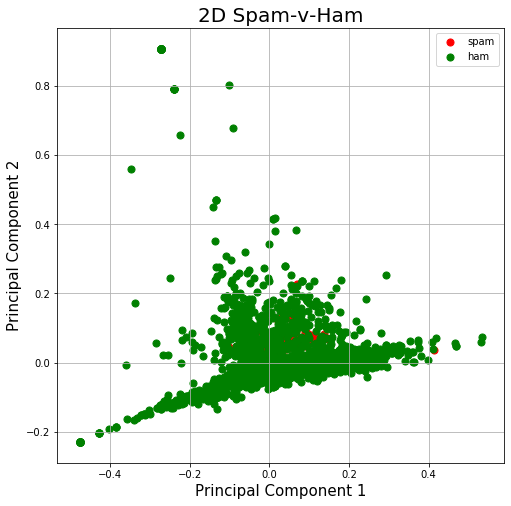

In [240]:
X, y = data[['text', 'length']], data['label']
uncleaned_bow_transformer = CountVectorizer().fit(corpus)
X_uncleaned = uncleaned_bow_transformer.transform(X['text'])
visualize_in_2d(X_trans.toarray(), y)

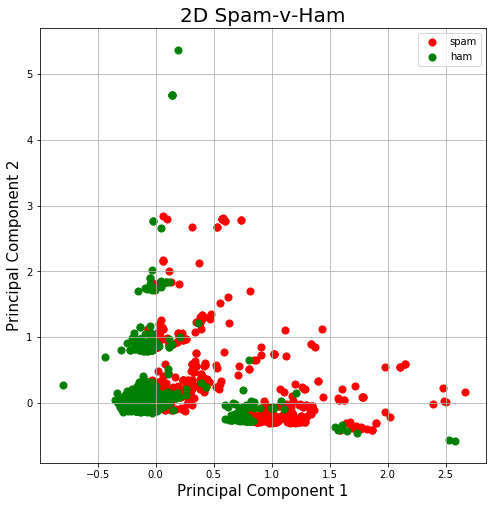

In [247]:
X_bow = bow_transformer.transform(X['text'])
visualize_in_2d(X_bow.toarray(), y)

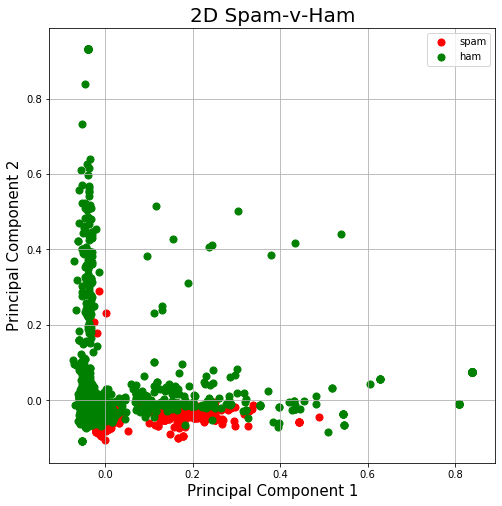

In [253]:
tfidf_transformer = TfidfVectorizer(tokenizer = preprocess).fit(corpus)
X_tfidf = tfidf_transformer.transform(data['text'])
visualize_in_2d(X_tfidf.toarray(), y)

### Word2Vec

In [78]:
model = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)  

In [80]:
model.most_similar(positive=['woman', 'king'], negative=['man'])

[('queen', 0.7118192911148071),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431607246399),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321243286133),
 ('kings', 0.5236844420433044),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.5181134343147278),
 ('sultan', 0.5098593235015869),
 ('monarchy', 0.5087411999702454)]

In [200]:
def text_2_vec(row):
    message = row['text']
    vector = np.zeros(300)
    for token in message:
        if token in model.vocab:
            vector += model[token]
    N = len(message)
    vector = (1/N) * vector
    vector = np.append(vector, row['length'])
    return vector

In [203]:
X_w2v = X.apply(text_2_vec, result_type='expand', axis=1)

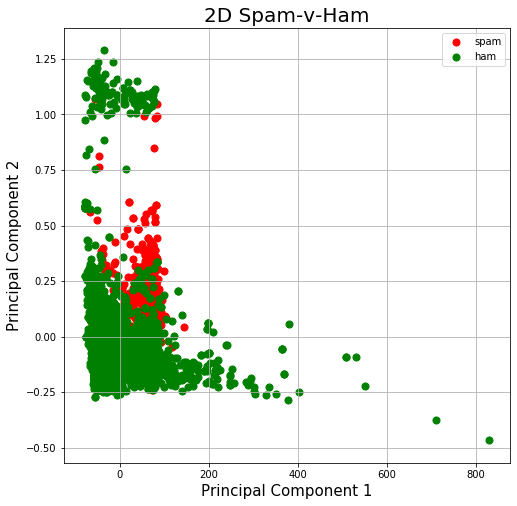

In [204]:
visualize_in_2d(X_w2v, y)

## Training Models

In [214]:
def train_test_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    model = SVC()
    model.fit(X_train, y_train)
    print('Model Score:', model.score(X_test, y_test))

In [248]:
Xs = [X_bow, X_tfidf, X_w2v]
for x in Xs:
    train_test_model(x, y)

/Users/nathan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Model Score: 0.8629690048939641


/Users/nathan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Model Score: 0.8629690048939641


/Users/nathan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Model Score: 0.88689505165851


In [268]:
print(np.sum(tfidf_transformer.transform([['I can show you the word shining simmering splendor'], ['this is a generic sentence']]).toarray()))
print(np.sum(bow_transformer.transform([['I can show you the word shining simmering splendor'], ['this is a generic sentence']]).toarray()))

AttributeError: 'list' object has no attribute 'lower'

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: text, dtype: object